In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns
sns.set_style("dark")

from sklearn import preprocessing
from scipy.stats import skew, boxcox

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 170)

In [19]:
df=pd.read_csv("/content/drive/MyDrive/Garanti/train.csv")

In [20]:
df.isnull().sum()

Id                0
step              0
action            0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [21]:
def checking_na(df):
    try:
        if (isinstance(df, pd.DataFrame)):
            df_na_bool = pd.concat([df.isnull().any(), df.isnull().sum(), (df.isnull().sum()/df.shape[0])*100],
                                   axis=1, keys=['df_bool', 'df_amt', 'missing_ratio_percent'])
            df_na_bool = df_na_bool.loc[df_na_bool['df_bool'] == True]
            return df_na_bool
        else:
            print("{}: The input is not panda DataFrame".format(now()))

    except (UnboundLocalError, RuntimeError):
        print("{}: Something is wrong".format(now()))


print(checking_na(df))

Empty DataFrame
Columns: [df_bool, df_amt, missing_ratio_percent]
Index: []


In [22]:
print(df.head(5))


   Id  step    action     amount     nameOrig  oldBalanceOrig  newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud
0   0     0  TRANSFER     10.000  C0198526315       30112.000       30102.000  C4653045645       21927.840       21937.840        0               0
1   1     1   CASH_IN 104925.190  C9864462944          42.230      104967.410  C7853342674           0.000           0.000        0               0
2   2     1   CASH_IN  37383.170  C1474610910          49.830       37433.010  C3584357969           0.000           0.000        0               0
3   3     1   CASH_IN 131908.490  C1474610910       37433.010      169341.490  C4996589500           0.000           0.000        0               0
4   4     1   CASH_IN 127105.650  C1474610910      169341.490      296447.140  C5989915138           0.000           0.000        0               0


In [23]:
print(df.describe())


               Id        step       amount  oldBalanceOrig  newBalanceOrig  oldBalanceDest  newBalanceDest     isFraud  isFlaggedFraud
count 2372805.000 2372805.000  2372805.000     2372805.000     2372805.000     2372805.000     2372805.000 2372805.000     2372805.000
mean  1676995.397     183.292   145451.915     3332225.906     3315864.113      282359.093      329937.822       0.000           0.000
std    967937.564     125.877   312216.482     1777182.891     1744701.630      955456.938     1138434.869       0.009           0.000
min         0.000       0.000        0.110     -195969.580     -195969.580     -143907.830      -62332.570       0.000           0.000
25%    838354.000      44.000    14368.890     2563357.130     2559985.750       21798.050       23911.350       0.000           0.000
50%   1677475.000     187.000    97853.080     3425072.270     3407158.830       77146.570       79652.160       0.000           0.000
75%   2515399.000     265.000   171409.560     4117519.

In [24]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372805 entries, 0 to 2372804
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Id              int64  
 1   step            int64  
 2   action          object 
 3   amount          float64
 4   nameOrig        object 
 5   oldBalanceOrig  float64
 6   newBalanceOrig  float64
 7   nameDest        object 
 8   oldBalanceDest  float64
 9   newBalanceDest  float64
 10  isFraud         int64  
 11  isFlaggedFraud  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 217.2+ MB
None


In [25]:
print('Number of Rows: {}'.format(df.shape[0]))
print('Number of Cols: {}'.format(df.shape[1]))

Number of Rows: 2372805
Number of Cols: 12


CASH_IN     1032064
CASH_OUT     560152
PAYMENT      553096
TRANSFER     139371
DEBIT         88122
Name: action, dtype: int64


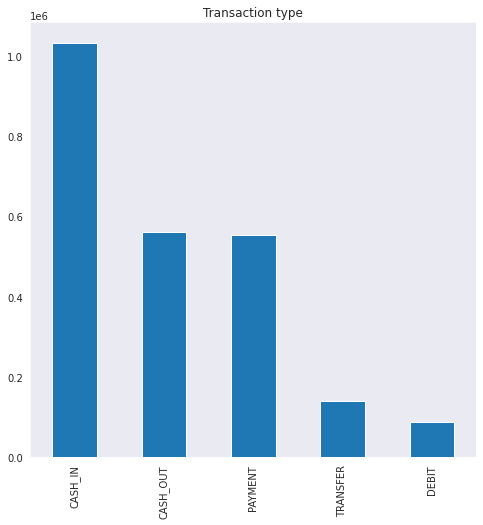

In [26]:
print(df.action.value_counts())

f, ax = plt.subplots(1, 1, figsize=(8, 8))
df.action.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

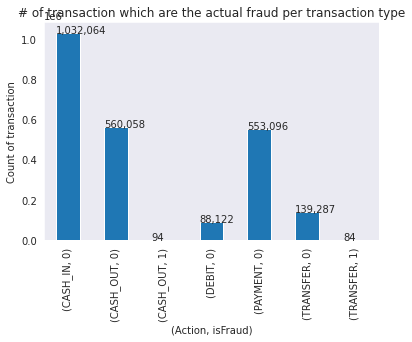

In [27]:
ax = df.groupby([ 'action','isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Action, isFraud)")
ax.set_ylabel("Count of transaction")


for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))

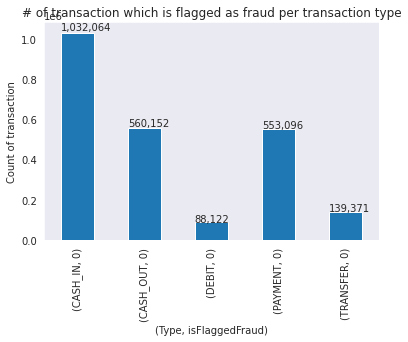

In [28]:
ax = df.groupby(['action', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which is flagged as fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

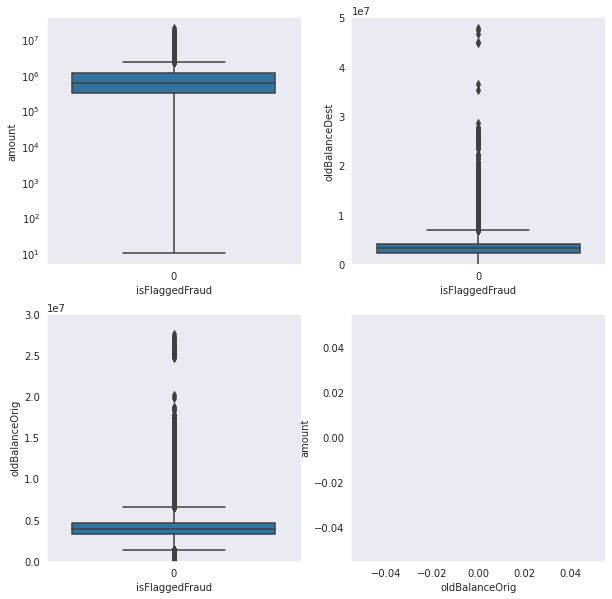

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
tmp = df.loc[(df.action == 'TRANSFER'), :]

a = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = tmp, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldBalanceDest', data = tmp, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldBalanceOrig', data=tmp, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))
d = sns.regplot(x = 'oldBalanceOrig', y = 'amount', data=tmp.loc[(tmp.isFlaggedFraud ==1), :], ax=axs[1][1])
plt.show()

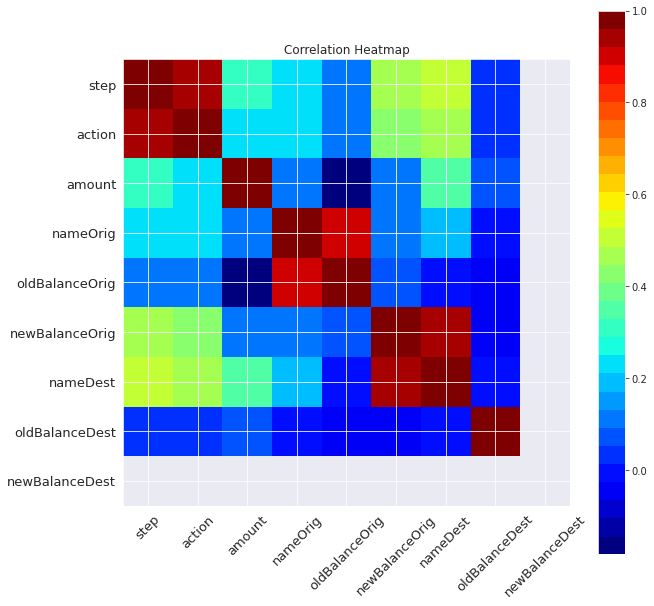

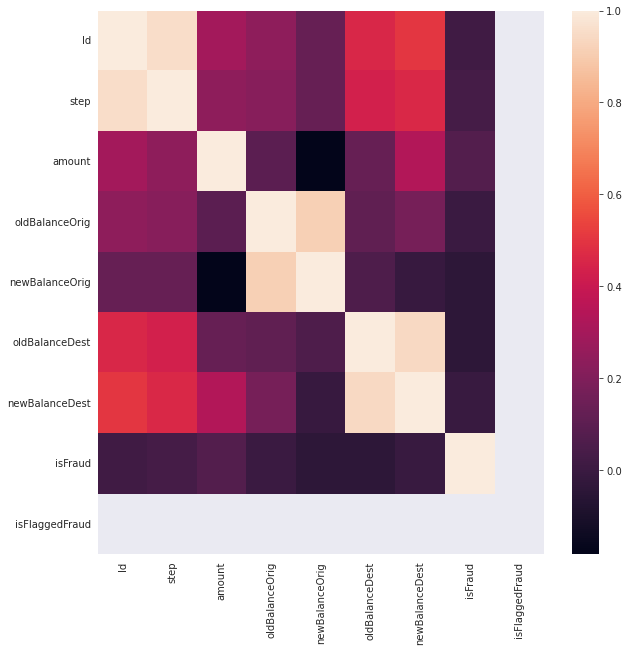

In [30]:
def correlation_plot(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
    ax1.grid(True)
    plt.title("Correlation Heatmap")
    labels = df.columns.tolist()
    ax1.set_xticklabels(labels, fontsize=13, rotation=45)
    ax1.set_yticklabels(labels, fontsize=13)
    fig.colorbar(cax)
    plt.show()
    
correlation_plot(tmp)

# Alternatively, we can use quick seaborn
# plot the heatmap

plt.figure(figsize=(10,10))
sns.heatmap(tmp.corr())



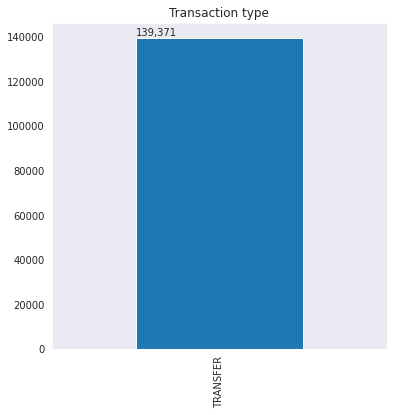

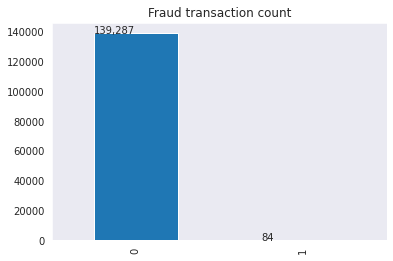

In [31]:
ax = tmp.action.value_counts().plot(kind='bar', title="Transaction type", figsize=(6,6))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

plt.show()

ax = pd.value_counts(tmp['isFraud'], sort = True).sort_index().plot(kind='bar', title="Fraud transaction count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    
plt.show()

In [32]:
print("The fraud transaction of the filtered dataset: {0:.4f}%".format((len(tmp[tmp.isFraud == 1])/len(tmp)) * 100))

The fraud transaction of the filtered dataset: 0.0603%


In [33]:
df.head()

,Id,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,0,0,TRANSFER,10.000,C0198526315,30112.000,30102.000,C4653045645,21927.840,21937.840,0,0
1,1,1,CASH_IN,104925.190,C9864462944,42.230,104967.410,C7853342674,0.000,0.000,0,0
2,2,1,CASH_IN,37383.170,C1474610910,49.830,37433.010,C3584357969,0.000,0.000,0,0
3,3,1,CASH_IN,131908.490,C1474610910,37433.010,169341.490,C4996589500,0.000,0.000,0,0
4,4,1,CASH_IN,127105.650,C1474610910,169341.490,296447.140,C5989915138,0.000,0.000,0,0


In [34]:
df.tail()

,Id,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2372800,3352878,718,TRANSFER,365959.080,C0575993734,9750032.160,9384073.080,C0205431023,7479928.580,7845887.660,0,0
2372801,3352879,718,CASH_OUT,51782.580,C8713379202,3457100.710,3405318.130,C2547402522,159726.220,159726.220,0,0
2372802,3352883,718,CASH_IN,74040.320,C4075734978,3009859.110,3083899.420,C2435516230,105711.720,105711.720,0,0
2372803,3352884,718,PAYMENT,11726.710,C8642260114,2980280.080,2968553.370,C5055233979,94282.560,106009.270,0,0
2372804,3352886,718,CASH_IN,115158.720,C0725945548,3599990.890,3715149.610,C1039537388,216298.600,216298.600,0,0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372805 entries, 0 to 2372804
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Id              int64  
 1   step            int64  
 2   action          object 
 3   amount          float64
 4   nameOrig        object 
 5   oldBalanceOrig  float64
 6   newBalanceOrig  float64
 7   nameDest        object 
 8   oldBalanceDest  float64
 9   newBalanceDest  float64
 10  isFraud         int64  
 11  isFlaggedFraud  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 217.2+ MB


In [36]:
df.isna().mean()

Id               0.000
step             0.000
action           0.000
amount           0.000
nameOrig         0.000
oldBalanceOrig   0.000
newBalanceOrig   0.000
nameDest         0.000
oldBalanceDest   0.000
newBalanceDest   0.000
isFraud          0.000
isFlaggedFraud   0.000
dtype: float64

In [37]:
df.drop(['oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest', 'amount', 'action'], axis=1, inplace=True)

X = df.iloc[:, tmp.columns != 'isFraud']
y = df.iloc[:, tmp.columns == 'isFraud']

IndexError: ignored

In [ ]:
X.head()


In [ ]:
# Number of data points in the minority class
number_records_fraud = len(tmp[tmp.isFraud == 1])
fraud_indices = tmp[tmp.isFraud == 1].index.values

# Picking the indices of the normal classes
normal_indices = tmp[tmp.isFraud == 0].index

# Out of the indices we picked, randomly select "x" number (x - same as total fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
under_sample_indices
under_sample_data = tmp.iloc[under_sample_indices]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'isFraud']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'isFraud']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.isFraud == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.isFraud == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

MACHINE LEARNING

In [ ]:
from sklearn.model_selection import train_test_split


# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

print("Number transactions train dataset: ", format(len(X_train),',d'))
print("Number transactions test dataset: ", format(len(X_test), ',d'))
print("Total number of transactions: ", format(len(X_train)+len(X_test), ',d'))





# Undersampled dataset
# X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
          #                                                                                         ,y_undersample
           #                                                                                        ,test_size = 0.3
            #                                                                                       ,random_state = 0)
#print("")
#print("Number transactions train dataset: ", format(len(X_train_undersample),',d'))
#print("Number transactions test dataset: ", format(len(X_test_undersample),',d'))
#print("Total number of transactions: ", format(len(X_train_undersample)+len(X_test_undersample),',d'))



In [ ]:
X_train.head()
